In [1]:
import tensorflow as tf
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def load_data(data_path):
    with open(data_path, "r") as f:
        data= json.load(f)
    X=np.array(data["MFCC"])
    y=np.array(data["Labels"])
    mapping = data["Genre"]
    return X, y, mapping


In [4]:
JSON_PATH= "Data\\Json\\Data.Json"
X, y, mapping = load_data(JSON_PATH )

In [36]:
plt.style.use('dark_background')

In [5]:
def split_data (X,y, val_size, split_size):
    #Split data into training set and testing set
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=split_size)
    #Split data into training set and validation set
    #data must be made into the shape of (X,Y,Z)
    X_train,X_val,y_train,y_val= train_test_split(X_train,y_train, test_size=val_size)
    X_train = X_train[...,np.newaxis]
    X_test = X_test[...,np.newaxis]
    X_val = X_val[...,np.newaxis]
    return X_train,y_train, X_val, y_val, X_test, y_test

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X,y, .15, .20)

In [7]:
def build_CNN (input_shape):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu',input_shape=input_shape))
    model.add(tf.keras.layers.MaxPool2D((3,3),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu',input_shape=input_shape))
    model.add(tf.keras.layers.MaxPool2D((3,3),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2D(64, (2,2), activation='relu',input_shape=input_shape))
    model.add(tf.keras.layers.MaxPool2D((2,2),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Dense(10, activation ='softmax'))
    return model

In [8]:
def build_CNNAlex (input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11), strides=(4,4), padding='same',activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #2nd Convolutional Layer
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same',activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #3rd Convolutional Layer
    model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())

    #4th Convolutional Layer
    model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())

    #5th Convolutional Layer
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #Passing it to a Fully Connected layer
    model.add(tf.keras.layers.Flatten())
    # 1st Fully Connected Layer
    model.add(tf.keras.layers.Dense(4096, input_shape=input_shape,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    # Add Dropout to prevent overfitting
    model.add(tf.keras.layers.Dropout(0.4))

    #2nd Fully Connected Layer
    model.add(tf.keras.layers.Dense(4096,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    #Add Dropout
    model.add(tf.keras.layers.Dropout(0.4))

    #3rd Fully Connected Layer
    model.add(tf.keras.layers.Dense(1000,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    #Add Dropout
    model.add(tf.keras.layers.Dropout(0.4))

    #Output Layer
    model.add(tf.keras.layers.Dense(10,activation ='softmax'))
    return model

In [9]:
model= build_CNN(X_train.shape[1:])
model_Alex=build_CNNAlex(X_train.shape[1:])

In [10]:
op = tf.keras.optimizers.Adam(learning_rate=0.0001)
callback=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=15,verbose=1)
model.compile(optimizer=op, loss='sparse_categorical_crossentropy', metrics=['accuracy'] )
model_Alex.compile(optimizer=op, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
model_history=model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=1000,callbacks=[callback])

Epoch 1/1000
213/213 [==============================] - 14s 21ms/step - loss: 2.3868 - accuracy: 0.2637 - val_loss: 1.5271 - val_accuracy: 0.4583
Epoch 2/1000
213/213 [==============================] - 1s 6ms/step - loss: 1.4821 - accuracy: 0.4803 - val_loss: 1.2275 - val_accuracy: 0.5618
Epoch 3/1000
213/213 [==============================] - 1s 7ms/step - loss: 1.2687 - accuracy: 0.5487 - val_loss: 1.0971 - val_accuracy: 0.6110
Epoch 4/1000
213/213 [==============================] - 1s 7ms/step - loss: 1.1298 - accuracy: 0.5940 - val_loss: 1.0430 - val_accuracy: 0.6336
Epoch 5/1000
213/213 [==============================] - 2s 7ms/step - loss: 1.0375 - accuracy: 0.6250 - val_loss: 0.9524 - val_accuracy: 0.6720
Epoch 6/1000
213/213 [==============================] - 2s 7ms/step - loss: 0.9646 - accuracy: 0.6602 - val_loss: 0.9676 - val_accuracy: 0.6611
Epoch 7/1000
213/213 [==============================] - 2s 7ms/step - loss: 0.8665 - accuracy: 0.6922 - val_loss: 0.8868 - val_accurac

In [12]:
model_history_Alex=model_Alex.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=1000,callbacks=[callback])

Epoch 1/1000
213/213 [==============================] - 14s 45ms/step - loss: 2.3102 - accuracy: 0.3659 - val_loss: 1.5584 - val_accuracy: 0.4040
Epoch 2/1000
213/213 [==============================] - 4s 20ms/step - loss: 1.4750 - accuracy: 0.5084 - val_loss: 1.4264 - val_accuracy: 0.5209
Epoch 3/1000
213/213 [==============================] - 5s 21ms/step - loss: 1.4819 - accuracy: 0.5131 - val_loss: 0.9843 - val_accuracy: 0.6678
Epoch 4/1000
213/213 [==============================] - 4s 20ms/step - loss: 1.3173 - accuracy: 0.5560 - val_loss: 1.0309 - val_accuracy: 0.6586
Epoch 5/1000
213/213 [==============================] - 4s 20ms/step - loss: 1.1773 - accuracy: 0.5863 - val_loss: 0.9759 - val_accuracy: 0.6845
Epoch 6/1000
213/213 [==============================] - 4s 20ms/step - loss: 1.0469 - accuracy: 0.6436 - val_loss: 1.0366 - val_accuracy: 0.6594
Epoch 7/1000
213/213 [==============================] - 5s 22ms/step - loss: 1.0771 - accuracy: 0.6394 - val_loss: 1.1934 - val_a

In [13]:
test_error, test_accuracy = model.evaluate(X_test, y_test)
print("Accuracy on test set is: {}".format(test_accuracy))

63/63 [==============================] - 2s 26ms/step - loss: 0.7407 - accuracy: 0.7902
Accuracy on test set is: 0.790185272693634


In [14]:
test_error2, test_accuracy2 = model_Alex.evaluate(X_test, y_test)
print("Accuracy on test set is: {}".format(test_accuracy2))

63/63 [==============================] - 2s 36ms/step - loss: 0.6348 - accuracy: 0.8142
Accuracy on test set is: 0.8142213225364685


In [15]:
X_predict=X_test[100]
y_predict=y_test[100]

In [16]:
X_predict= X_predict[np.newaxis, ...]

In [17]:
pred=model.predict(X_predict)

In [18]:
pred_1=np.argmax(pred)
print("Prediction with {}%: Pred:{} Accutal: {}".format(pred[0][pred_1],mapping[pred_1],mapping[y_predict]))

Prediction with 0.5644429326057434%: Pred:classical Accutal: rock


In [19]:
pred_2=model_Alex.predict(X_predict)
pred_02=np.argmax(pred_2)
print("Prediction with {}%: Pred:{} Accutal: {}".format(pred_2[0][pred_02],mapping[pred_02],mapping[y_predict]))

Prediction with 0.5499559640884399%: Pred:classical Accutal: rock


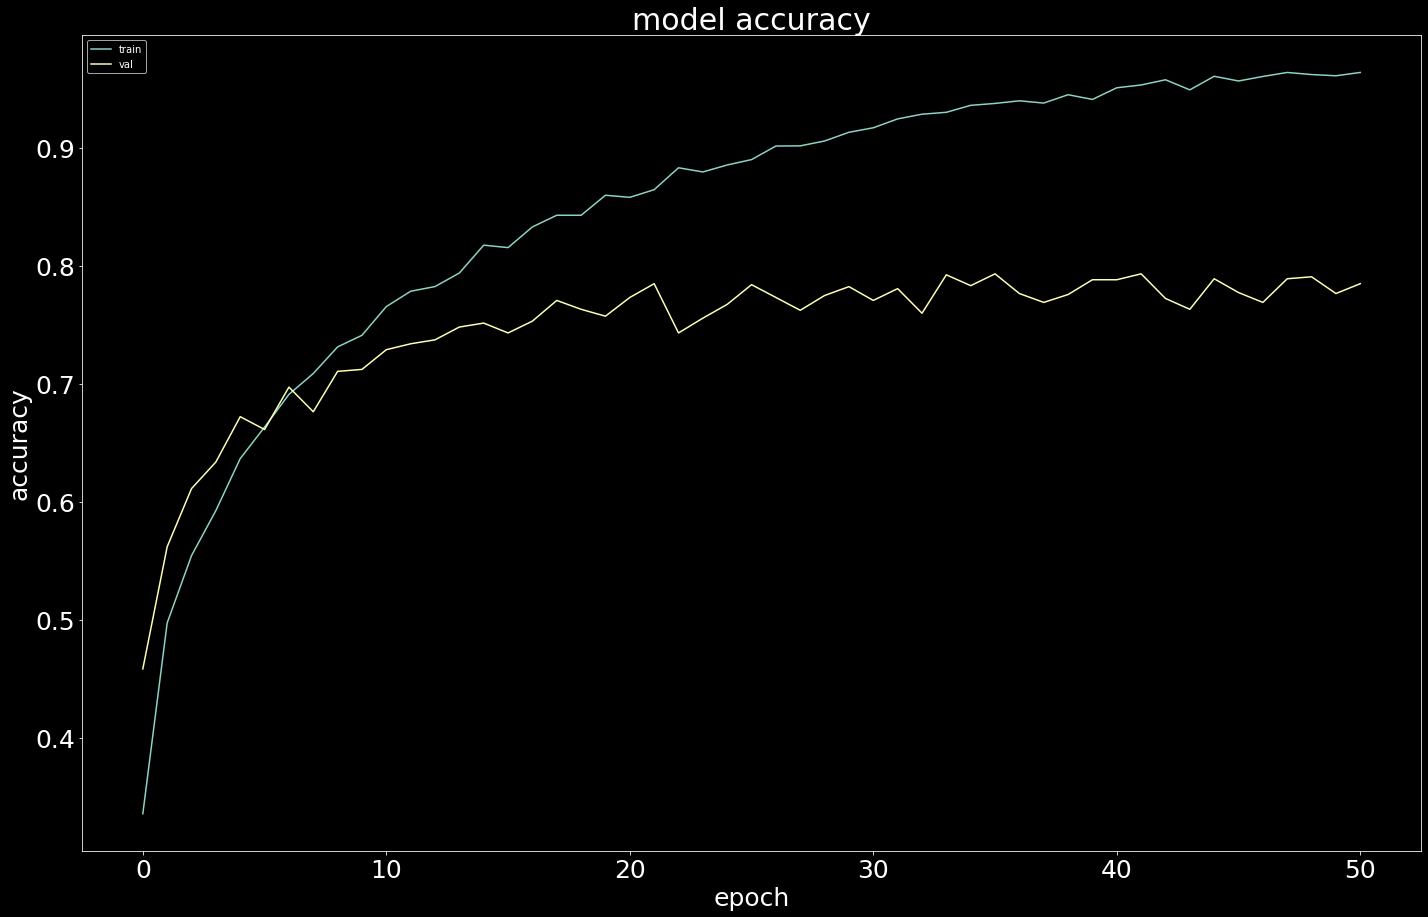

In [37]:
plt.rc('axes', titlesize=30)
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25) 
plt.figure(figsize=(24,15))
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

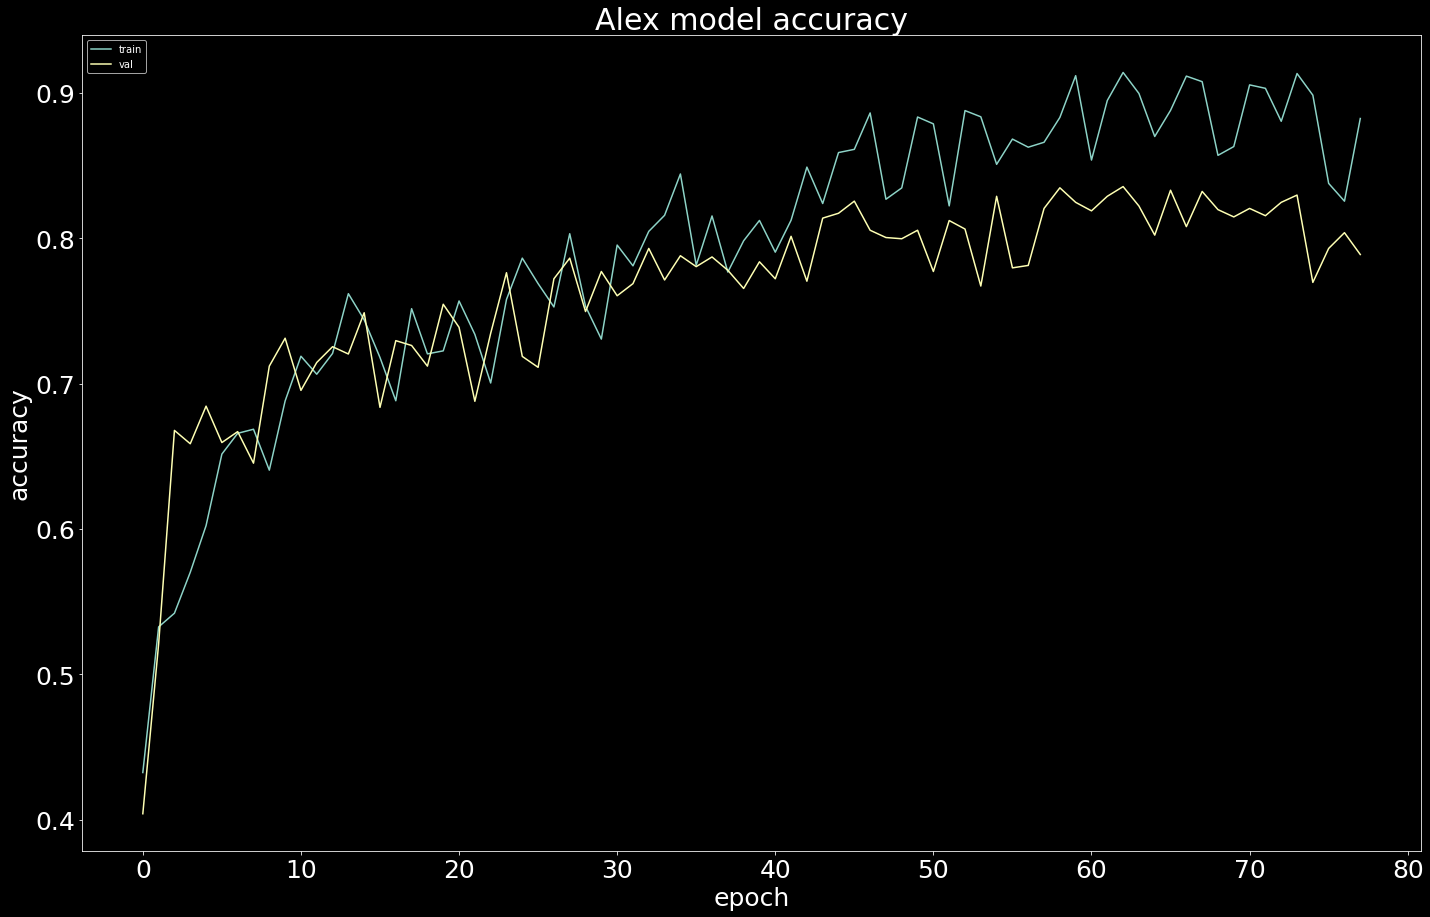

In [38]:
plt.rc('axes', titlesize=30)
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25) 
plt.figure(figsize=(24,15))
plt.plot(model_history_Alex.history['accuracy'])
plt.plot(model_history_Alex.history['val_accuracy'])
plt.title('Alex model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
pred=model.predict(X_test)
alex_pred=model_Alex.predict(X_test)

In [23]:
model.save('my_model.h5')
model_Alex.save('my_model_Alex.h5')

In [24]:
index_array = np.argmax(pred, axis=-1)
index_array_alex=np.argmax(alex_pred,axis=-1)

In [25]:
confusion=tf.math.confusion_matrix(y_test,index_array)
confusion_Alex=tf.math.confusion_matrix(y_test,index_array_alex)

Text(181.0, 0.5, 'label')

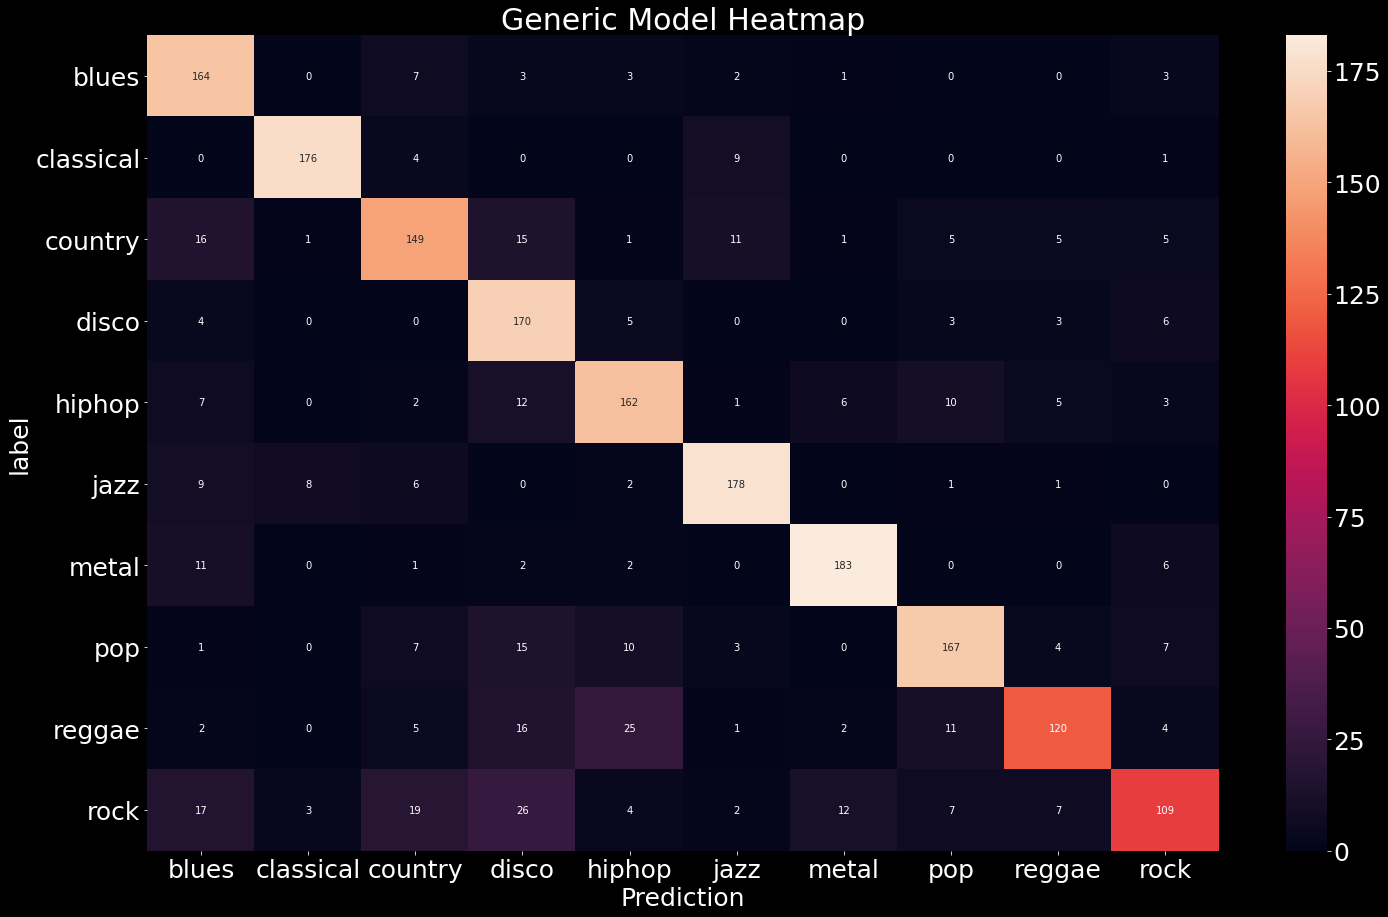

In [39]:
plt.rc('axes', titlesize=30)
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25) 
plt.figure(figsize=(24,15))
sns.heatmap(confusion,xticklabels=mapping,yticklabels=mapping, annot=True, fmt='g')
plt.title("Generic Model Heatmap")
plt.xlabel('Prediction')
plt.ylabel('label')

Text(181.0, 0.5, 'label')

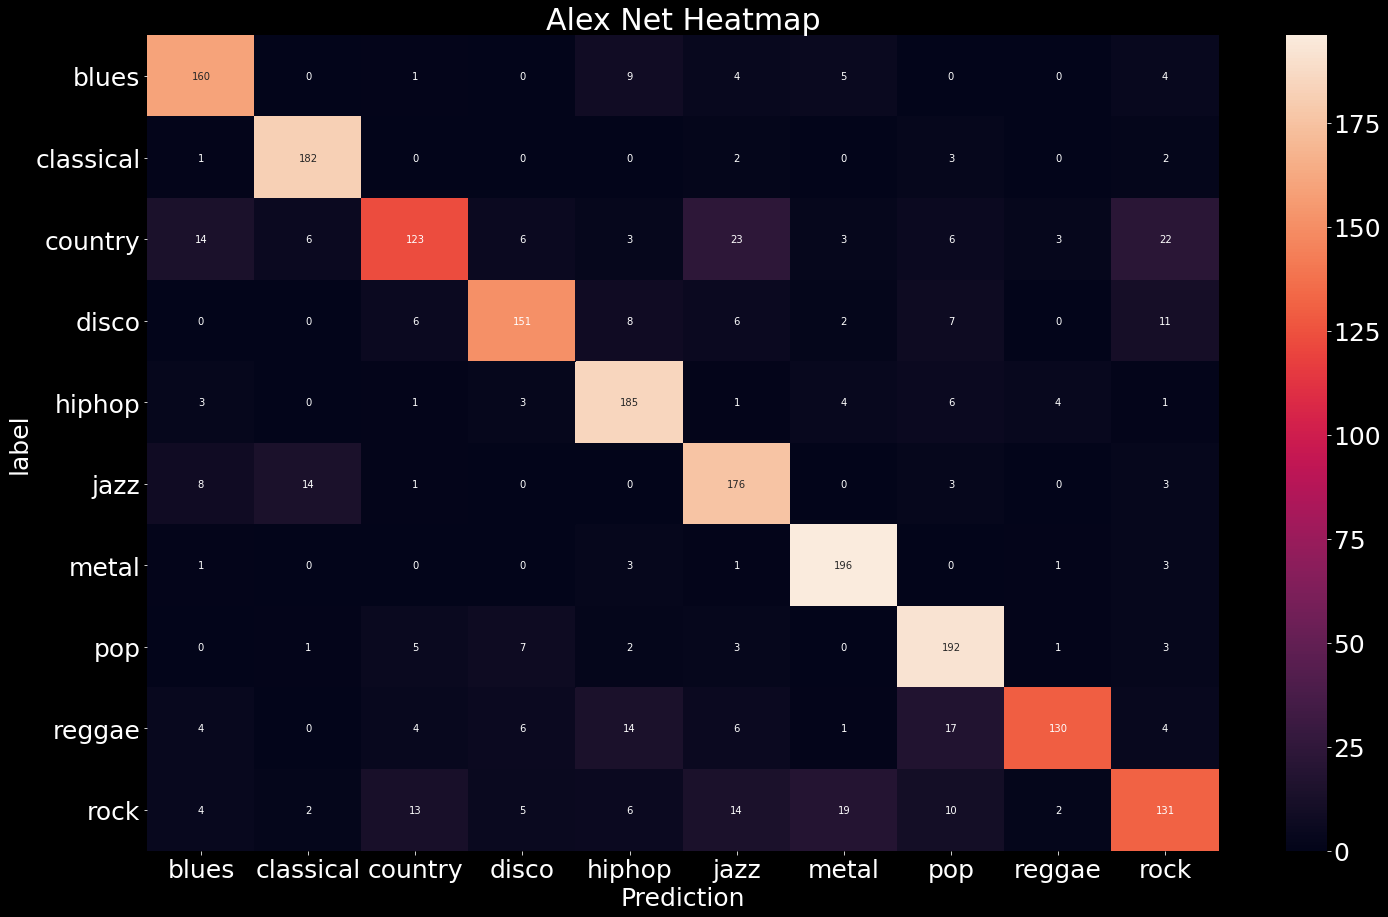

In [40]:
plt.rc('axes', titlesize=30)
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25) 
plt.figure(figsize=(24,15))
sns.heatmap(confusion_Alex,xticklabels=mapping,yticklabels=mapping, annot=True, fmt='g')
plt.title("Alex Net Heatmap")
plt.xlabel('Prediction')
plt.ylabel('label')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 64)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 64)         256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 64)         36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 64)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 64)         256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 64)         1

In [29]:
model_Alex.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 33, 4, 96)         11712     
_________________________________________________________________
batch_normalization_3 (Batch (None, 33, 4, 96)         384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 2, 96)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 2, 256)        614656    
_________________________________________________________________
batch_normalization_4 (Batch (None, 17, 2, 256)        1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 1, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 1, 384)        